# Live demo: Processing gravity data with Fatiando a Terra

This notebook is based on the [Fatiando tutorial for processing gravity data](https://github.com/fatiando/tutorials).

## Import packages

In [1]:
import pygmt
import pyproj
import numpy as np
import pandas as pd
import xarray as xr

import ensaio
import verde as vd
import boule as bl
import harmonica as hm

## Load gravity data for Bushveld Igenous Complex (Southern Africa) and a DEM

We can use [Ensaio](https://www.fatiando.org/ensaio) to download our sample data files.
Let's download some gravity data of the Bushveld Igenous Complex, Southern Africa:

In [2]:
fname = ensaio.fetch_bushveld_gravity(version=1)
fname

PosixPath('/home/santi/.cache/ensaio/v1/bushveld-gravity.csv.xz')

And use Pandas for reading the csv file

In [3]:
data = pd.read_csv(fname).drop(columns=["gravity_disturbance_mgal", "gravity_bouguer_mgal"])
data

,longitude,latitude,height_sea_level_m,height_geometric_m,gravity_mgal
0,25.01500,-26.26334,1230.2,1257.474535,978681.38
1,25.01932,-26.38713,1297.0,1324.574150,978669.02
2,25.02499,-26.39667,1304.8,1332.401322,978669.28
3,25.04500,-26.07668,1165.2,1192.107148,978681.08
4,25.07668,-26.35001,1262.5,1289.971792,978665.19
...,...,...,...,...,...
3872,31.51500,-23.86333,300.5,312.710241,978776.85
3873,31.52499,-23.30000,280.7,292.686630,978798.55
3874,31.54832,-23.19333,245.7,257.592670,978803.55
3875,31.57333,-23.84833,226.8,239.199065,978808.44


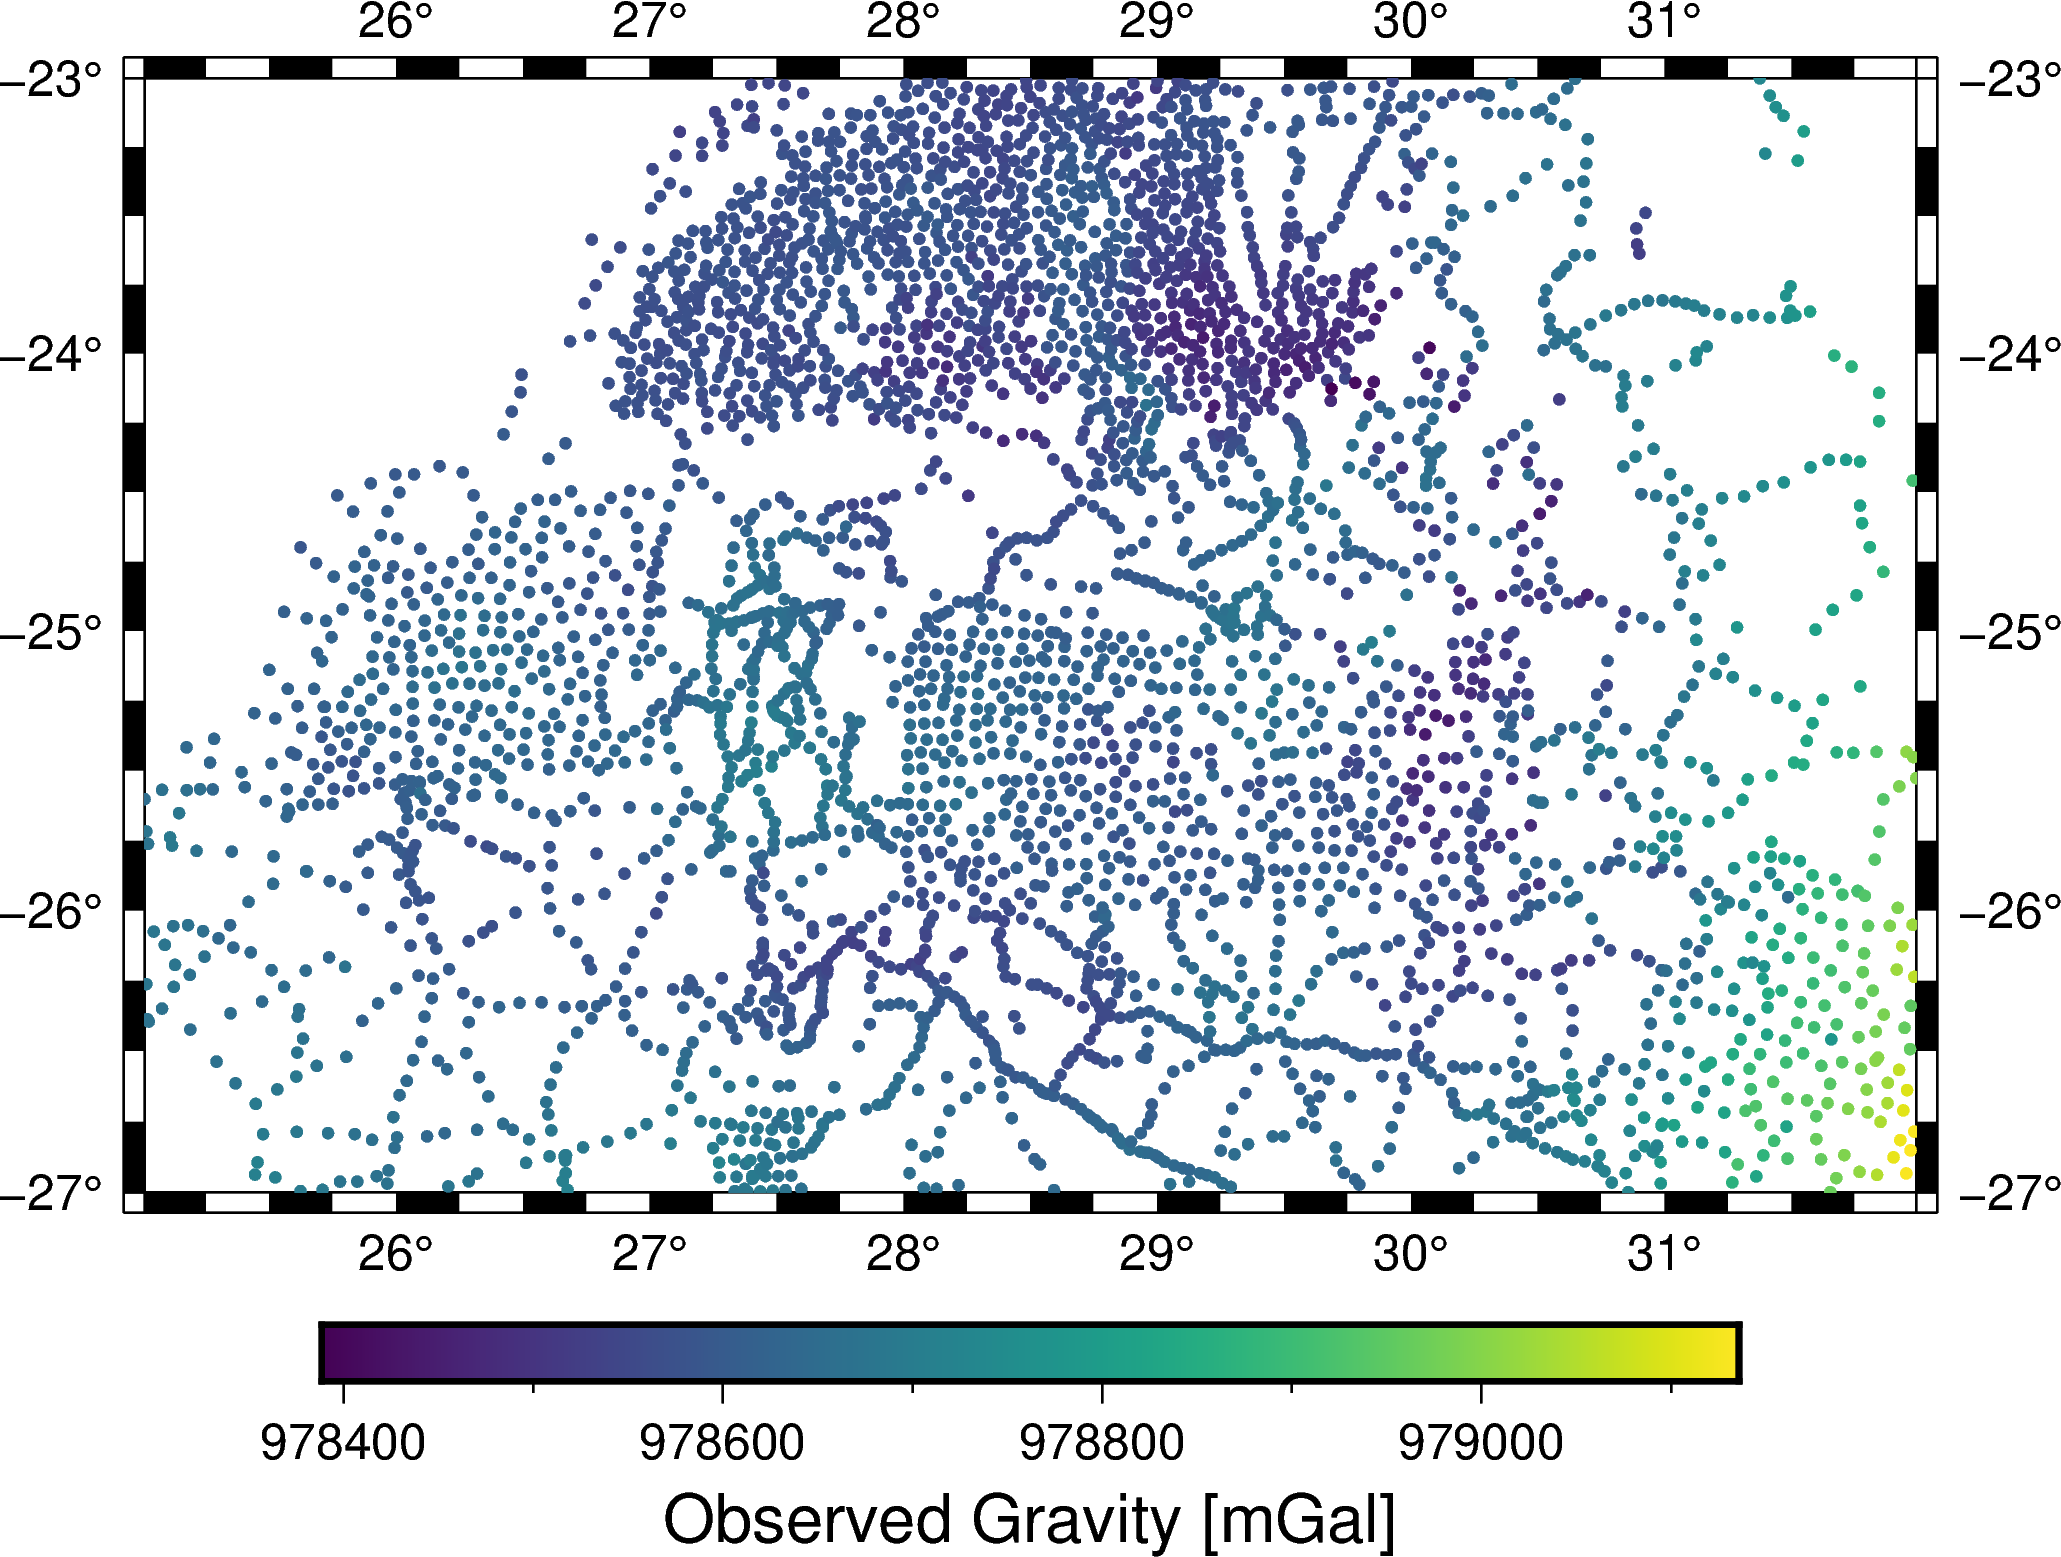

In [4]:
# Obtain the region to plot using Verde ([W, E, S, N])
region_deg = vd.get_region((data.longitude, data.latitude))

fig = pygmt.Figure()
fig.basemap(projection="M15c", region=region_deg, frame=True)
pygmt.makecpt(cmap="viridis", series=[data.gravity_mgal.min(), data.gravity_mgal.max()])
fig.plot(
    x=data.longitude,
    y=data.latitude,
    color=data.gravity_mgal,
    cmap=True,
    style="c0.1c",
)
fig.colorbar(frame='af+l"Observed Gravity [mGal]"')
fig.show()

Let's download a DEM for Southern Africa:

In [5]:
fname = ensaio.fetch_southern_africa_topography(version=1)
fname

PosixPath('/home/santi/.cache/ensaio/v1/southern-africa-topography.nc')

And use Xarray to load the netCDF file:

In [6]:
topography = xr.load_dataarray(fname)
topography

<xarray.DataArray 'topography' (latitude: 1182, longitude: 1371)>
array([[-5039., -5027., -5014., ..., -3846., -3867., -3873.],
       [-5036., -5021., -5007., ..., -3839., -3863., -3872.],
       [-5031., -5016., -5001., ..., -3835., -3860., -3870.],
       ...,
       [-2906., -2901., -2884., ...,   173.,   134.,   118.],
       [-2908., -2906., -2888., ...,   132.,   119.,   118.],
       [-2912., -2910., -2894., ...,   122.,   120.,   128.]],
      dtype=float32)
Coordinates:
  * longitude  (longitude) float64 10.92 10.93 10.95 10.97 ... 33.72 33.73 33.75
  * latitude   (latitude) float64 -36.0 -35.98 -35.97 ... -16.35 -16.33 -16.32
Attributes:
    Conventions:    CF-1.8
    title:          Topographic and bathymetric height for Southern Africa ob...
    crs:            WGS84
    source:         Downloaded from NOAA website (https://ngdc.noaa.gov/mgg/g...
    license:        public domain
    references:     https://doi.org/10.7289/V5C8276M
    long_name:      topographic height above mean sea level
    standard_name:  height_above_mean_sea_level
    description:    height topography/bathymetry referenced to mean sea level
    units:          m
    actual_range:   [-5685.  3376.]
    noaa_metadata:  Conventions: COARDS/CF-1.0\ntitle: ETOPO1_Ice_g_gmt4.grd\...

### Crop the topography around Bushveld Igeneous complex area

In [7]:
region = vd.get_region((data.longitude, data.latitude))

region_pad = vd.pad_region(region, 1)
region_pad

(24.00806, 32.99167, -28.0, -22.0)

In [8]:
topography = topography.sel(
    longitude=slice(*region_pad[:2]),
    latitude=slice(*region_pad[2:]),
)
topography

<xarray.DataArray 'topography' (latitude: 360, longitude: 539)>
array([[ 1408.,  1403.,  1398., ..., -1300., -1316., -1336.],
       [ 1413.,  1406.,  1400., ..., -1292., -1305., -1319.],
       [ 1415.,  1409.,  1402., ..., -1284., -1295., -1306.],
       ...,
       [  970.,   972.,   973., ...,   121.,   120.,   122.],
       [  970.,   973.,   974., ...,   121.,   120.,   123.],
       [  967.,   970.,   974., ...,   122.,   122.,   123.]],
      dtype=float32)
Coordinates:
  * longitude  (longitude) float64 24.02 24.03 24.05 24.07 ... 32.95 32.97 32.98
  * latitude   (latitude) float64 -28.0 -27.98 -27.97 ... -22.05 -22.03 -22.02
Attributes:
    Conventions:    CF-1.8
    title:          Topographic and bathymetric height for Southern Africa ob...
    crs:            WGS84
    source:         Downloaded from NOAA website (https://ngdc.noaa.gov/mgg/g...
    license:        public domain
    references:     https://doi.org/10.7289/V5C8276M
    long_name:      topographic height above mean sea level
    standard_name:  height_above_mean_sea_level
    description:    height topography/bathymetry referenced to mean sea level
    units:          m
    actual_range:   [-5685.  3376.]
    noaa_metadata:  Conventions: COARDS/CF-1.0\ntitle: ETOPO1_Ice_g_gmt4.grd\...

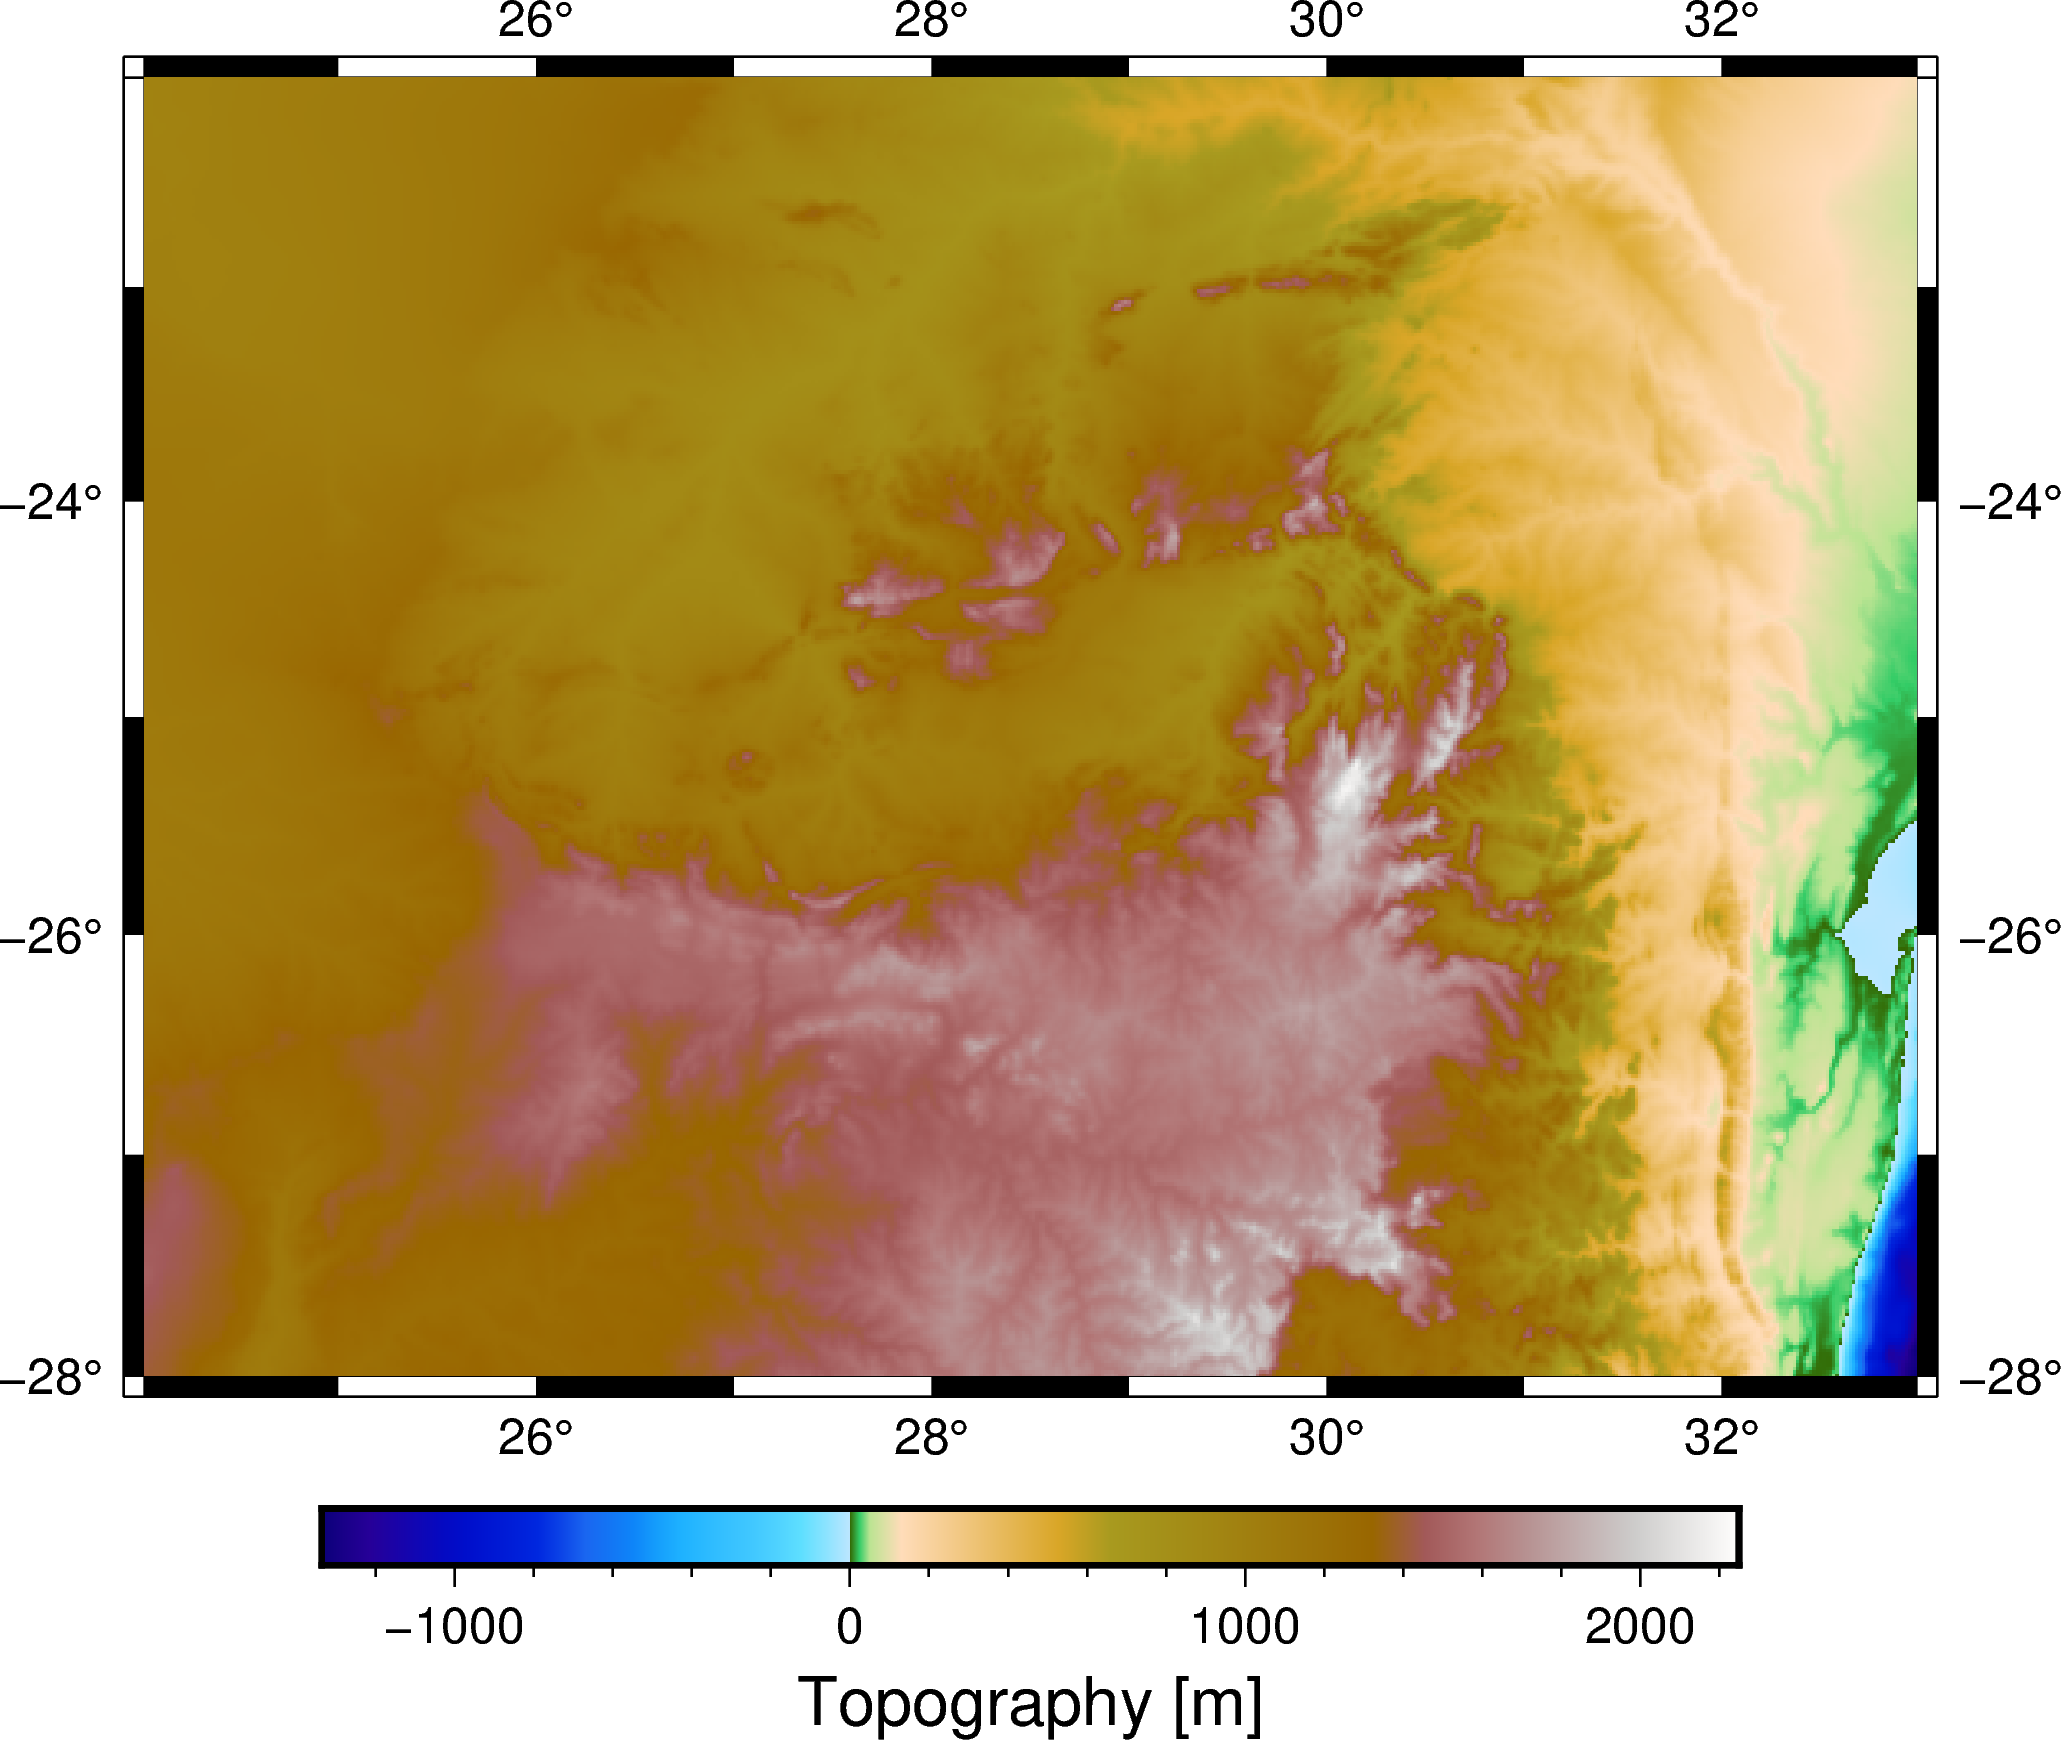

In [9]:
# Plot topography using pygmt
fig = pygmt.Figure()
topo_region = vd.get_region((topography.longitude.values, topography.latitude.values))
fig.basemap(projection="M15c", region=topo_region, frame=True)

vmin, vmax = topography.values.min(), topography.values.max()
pygmt.makecpt(cmap="etopo1", series=[vmin, vmax])
fig.grdimage(topography)

fig.colorbar(frame='af+l"Topography [m]"')
fig.show()

## Compute gravity disturbance

We can use [Boule](https://www.fatiando.org/boule) to compute the normal gravity of the WGS84 reference ellipsoid on any point.

In [10]:
ellipsoid = bl.WGS84
normal_gravity = ellipsoid.normal_gravity(data.latitude, data.height_geometric_m)
normal_gravity

0       978656.298408
1       978644.481842
2       978642.753040
3       978663.125186
4       978652.489693
            ...      
3872    978781.633965
3873    978750.537234
3874    978754.388229
3875    978803.323096
3876    978729.583074
Length: 3877, dtype: float64

And compute the gravity disturbance as the difference between the observed gravity and the normal gravity:

In [11]:
data["gravity_disturbance_mgal"] = data.gravity_mgal - normal_gravity
data

,longitude,latitude,height_sea_level_m,height_geometric_m,gravity_mgal,gravity_disturbance_mgal
0,25.01500,-26.26334,1230.2,1257.474535,978681.38,25.081592
1,25.01932,-26.38713,1297.0,1324.574150,978669.02,24.538158
2,25.02499,-26.39667,1304.8,1332.401322,978669.28,26.526960
3,25.04500,-26.07668,1165.2,1192.107148,978681.08,17.954814
4,25.07668,-26.35001,1262.5,1289.971792,978665.19,12.700307
...,...,...,...,...,...,...
3872,31.51500,-23.86333,300.5,312.710241,978776.85,-4.783965
3873,31.52499,-23.30000,280.7,292.686630,978798.55,48.012766
3874,31.54832,-23.19333,245.7,257.592670,978803.55,49.161771
3875,31.57333,-23.84833,226.8,239.199065,978808.44,5.116904


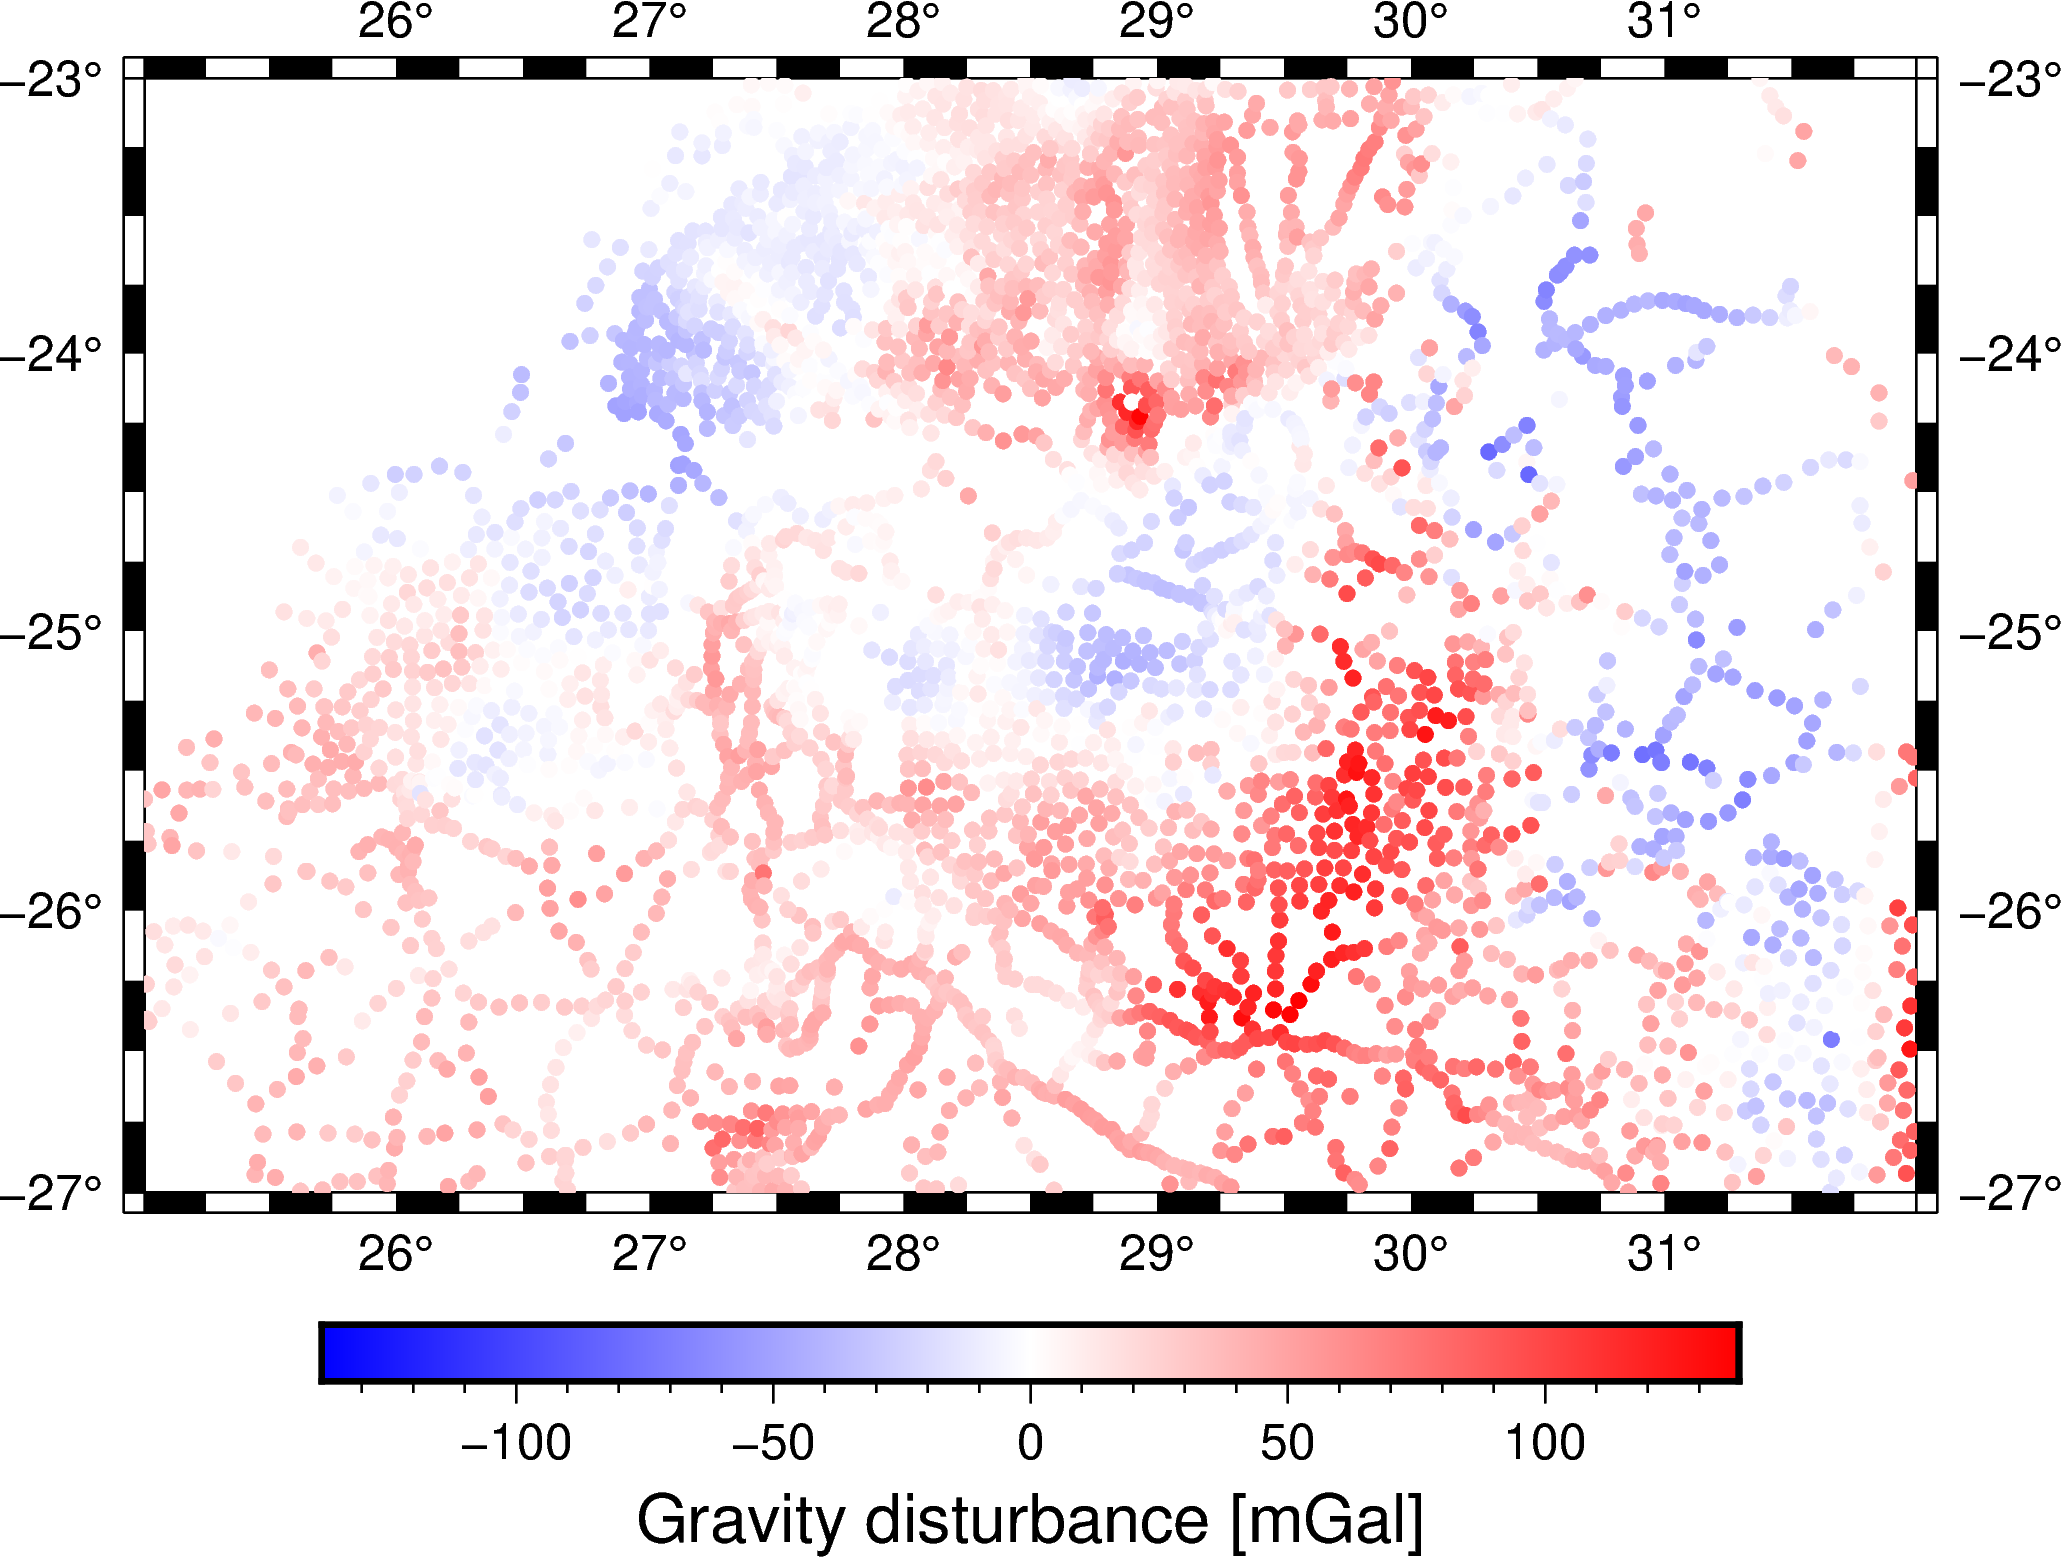

In [12]:
fig = pygmt.Figure()
fig.basemap(projection="M15c", region=region_deg, frame=True)

maxabs = vd.maxabs(data.gravity_disturbance_mgal)
pygmt.makecpt(cmap="polar", series=[-maxabs, maxabs])
fig.plot(
    x=data.longitude,
    y=data.latitude,
    color=data.gravity_disturbance_mgal,
    cmap=True,
    style="c4p",
)

fig.colorbar(frame='af+l"Gravity disturbance [mGal]"')
fig.show()

## Remove terrain effect

We can use [Harmonica](https://www.fatiando.org/harmonica) for forward modelling the gravitational effect of the terrain through rectangular prisms.
To do so we need to project the coordinates of the data and the DEM to plain coordinates.

### Project the data to plain coordinates

Define the Mercator projeciton using `pyproj`:

In [13]:
projection = pyproj.Proj(proj="merc", lat_ts=data.latitude.mean())

In [14]:
easting, northing = projection(data.longitude.values, data.latitude.values)

In [15]:
data["easting"] = easting
data["northing"] = northing
data

,longitude,latitude,height_sea_level_m,height_geometric_m,gravity_mgal,gravity_disturbance_mgal,easting,northing
0,25.01500,-26.26334,1230.2,1257.474535,978681.38,25.081592,2.526066e+06,-2.733052e+06
1,25.01932,-26.38713,1297.0,1324.574150,978669.02,24.538158,2.526503e+06,-2.746924e+06
2,25.02499,-26.39667,1304.8,1332.401322,978669.28,26.526960,2.527075e+06,-2.747994e+06
3,25.04500,-26.07668,1165.2,1192.107148,978681.08,17.954814,2.529096e+06,-2.712163e+06
4,25.07668,-26.35001,1262.5,1289.971792,978665.19,12.700307,2.532295e+06,-2.742763e+06
...,...,...,...,...,...,...,...,...
3872,31.51500,-23.86333,300.5,312.710241,978776.85,-4.783965,3.182450e+06,-2.466945e+06
3873,31.52499,-23.30000,280.7,292.686630,978798.55,48.012766,3.183459e+06,-2.405224e+06
3874,31.54832,-23.19333,245.7,257.592670,978803.55,49.161771,3.185814e+06,-2.393567e+06
3875,31.57333,-23.84833,226.8,239.199065,978808.44,5.116904,3.188340e+06,-2.465298e+06


### Project the topography to plain coordinates

In [16]:
topo_plain = vd.project_grid(topography, projection=projection, method="nearest")
topo_plain

/home/santi/.mambaforge/envs/iag-usp-2022-talk/lib/python3.9/site-packages/verde/base/base_classes.py:463: FutureWarning: The 'spacing', 'shape' and 'region' arguments will be removed in Verde v2.0.0. Please use the 'verde.grid_coordinates' function to define grid coordinates and pass them as the 'coordinates' argument.
  warnings.warn(


<xarray.DataArray 'topography' (northing: 360, easting: 539)>
array([[ 1408. ,  1403. ,  1398. , ..., -1300. , -1326. , -1326. ],
       [ 1409.5,  1409.5,  1399. , ..., -1292. , -1312. , -1312. ],
       [ 1412. ,  1412. ,  1399.5, ..., -1289.5, -1289.5, -1306. ],
       ...,
       [  971. ,   971. ,   974. , ...,   121. ,   121. ,   121. ],
       [  970. ,   970. ,   974.5, ...,   121.5,   122. ,   122. ],
       [  970. ,   970. ,   974.5, ...,   121.5,   122. ,   122. ]],
      dtype=float32)
Coordinates:
  * easting   (easting) float64 2.425e+06 2.427e+06 ... 3.329e+06 3.331e+06
  * northing  (northing) float64 -2.929e+06 -2.927e+06 ... -2.267e+06 -2.266e+06
Attributes:
    metadata:  Generated by Chain(steps=[('mean',\n              BlockReduce(...

### Compute gravitational effect of the layer of prisms

Create a model of the terrain with prisms


![](nb-images/prisms.svg)

In [17]:
density = np.where(topo_plain >=0, 2670, 1040 - 2670)

topo_prisms = hm.prism_layer(
    coordinates=(topo_plain.easting, topo_plain.northing),
    surface=topo_plain,
    reference=0,
    properties={"density": density},
)
topo_prisms

<xarray.Dataset>
Dimensions:   (northing: 360, easting: 539)
Coordinates:
  * easting   (easting) float64 2.425e+06 2.427e+06 ... 3.329e+06 3.331e+06
  * northing  (northing) float64 -2.929e+06 -2.927e+06 ... -2.267e+06 -2.266e+06
    top       (northing, easting) float32 1.408e+03 1.403e+03 ... 122.0 122.0
    bottom    (northing, easting) float64 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
Data variables:
    density   (northing, easting) int64 2670 2670 2670 2670 ... 2670 2670 2670
Attributes:
    coords_units:      meters
    properties_units:  SI

Calculate the gravitational effect of the terrain

In [18]:
coordinates = (data.easting, data.northing, data.height_geometric_m)
%time terrain_effect = topo_prisms.prism_layer.gravity(coordinates, field="g_z")
terrain_effect

CPU times: user 7min 57s, sys: 504 ms, total: 7min 58s
Wall time: 1min 5s


array([139.26661539, 145.71474472, 145.57628834, ...,  28.05937687,
        26.21527443,  32.41694879])

Calculate the Bouguer disturbance

In [19]:
data["bouguer_mgal"] = data.gravity_disturbance_mgal - terrain_effect
data

,longitude,latitude,height_sea_level_m,height_geometric_m,gravity_mgal,gravity_disturbance_mgal,easting,northing,bouguer_mgal
0,25.01500,-26.26334,1230.2,1257.474535,978681.38,25.081592,2.526066e+06,-2.733052e+06,-114.185023
1,25.01932,-26.38713,1297.0,1324.574150,978669.02,24.538158,2.526503e+06,-2.746924e+06,-121.176587
2,25.02499,-26.39667,1304.8,1332.401322,978669.28,26.526960,2.527075e+06,-2.747994e+06,-119.049329
3,25.04500,-26.07668,1165.2,1192.107148,978681.08,17.954814,2.529096e+06,-2.712163e+06,-113.377276
4,25.07668,-26.35001,1262.5,1289.971792,978665.19,12.700307,2.532295e+06,-2.742763e+06,-127.514553
...,...,...,...,...,...,...,...,...,...
3872,31.51500,-23.86333,300.5,312.710241,978776.85,-4.783965,3.182450e+06,-2.466945e+06,-38.175257
3873,31.52499,-23.30000,280.7,292.686630,978798.55,48.012766,3.183459e+06,-2.405224e+06,15.800429
3874,31.54832,-23.19333,245.7,257.592670,978803.55,49.161771,3.185814e+06,-2.393567e+06,21.102395
3875,31.57333,-23.84833,226.8,239.199065,978808.44,5.116904,3.188340e+06,-2.465298e+06,-21.098370


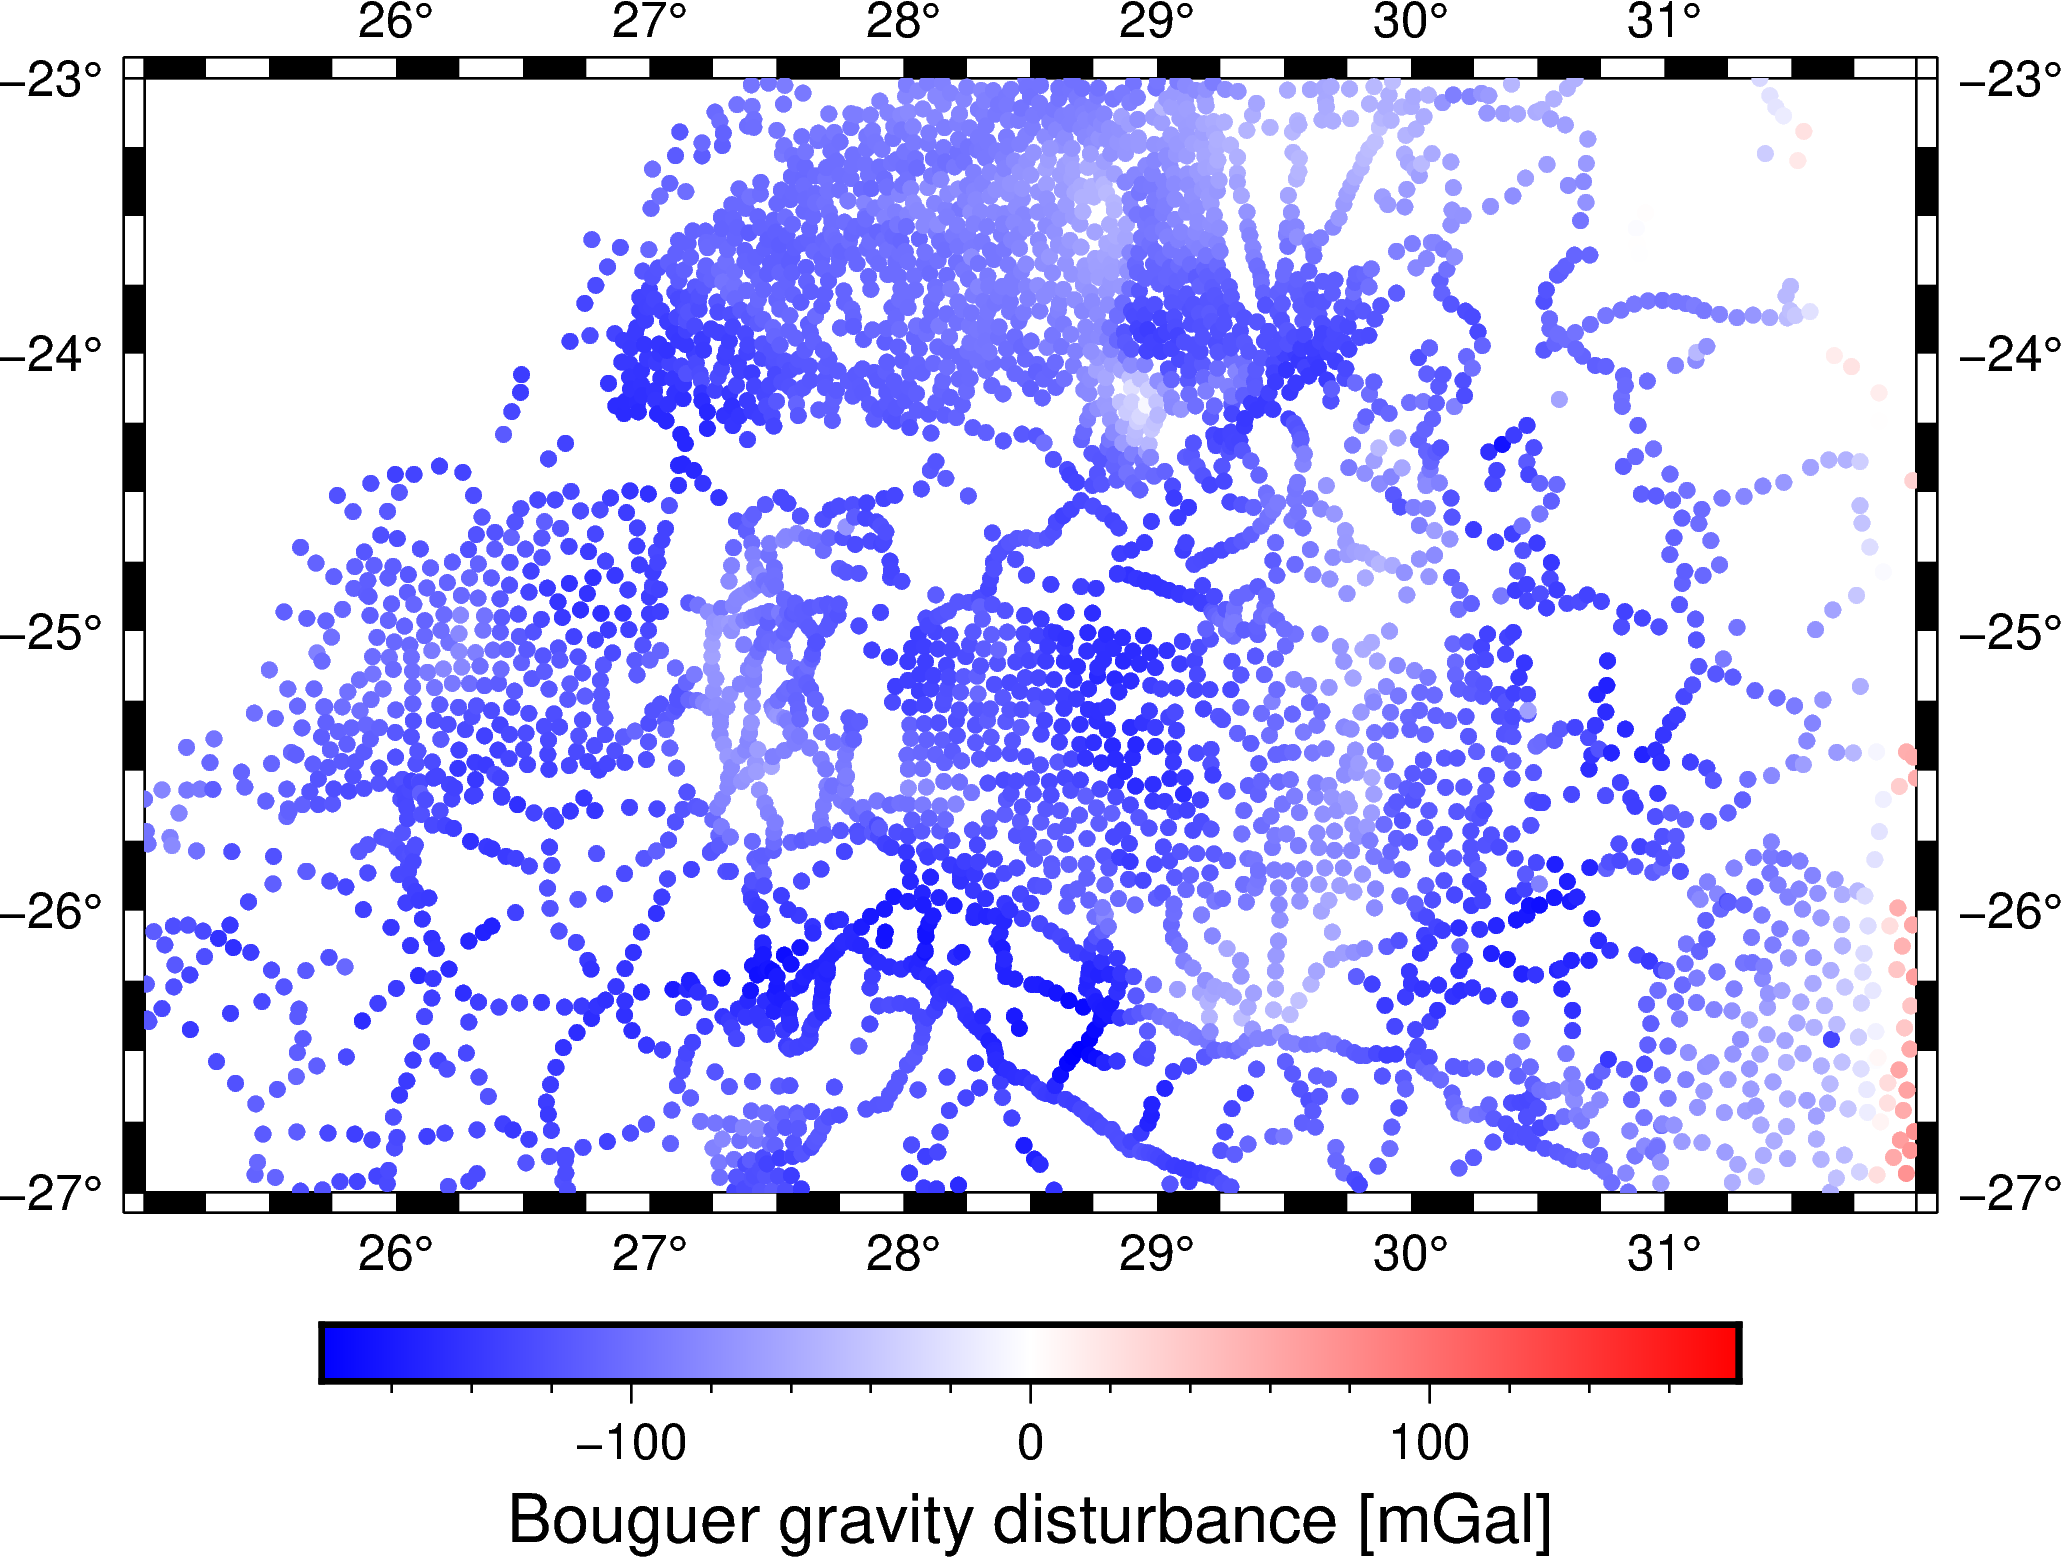

In [20]:
fig = pygmt.Figure()
fig.basemap(projection="M15c", region=region_deg, frame=True)

maxabs = vd.maxabs(data.bouguer_mgal)
pygmt.makecpt(cmap="polar", series=[-maxabs, maxabs])
fig.plot(
    x=data.longitude,
    y=data.latitude,
    color=data.bouguer_mgal,
    cmap=True,
    style="c4p",
)
fig.colorbar(frame='af+l"Bouguer gravity disturbance [mGal]"')
fig.show()

## Calculate residuals

We can calculate a regional field by defining deep equivalent sources with [Harmonica](https://www.fatiando.org/harmonica):

![](nb-images/equivalent-sources.svg)

In [21]:
deep_sources = hm.EquivalentSources(damping=1000, depth=1000e3)

coordinates = (data.easting, data.northing, data.height_geometric_m)
deep_sources.fit(coordinates, data.bouguer_mgal)

residuals = data.bouguer_mgal - deep_sources.predict(coordinates)

In [22]:
data["residuals_mgal"] = residuals
data

,longitude,latitude,height_sea_level_m,height_geometric_m,gravity_mgal,gravity_disturbance_mgal,easting,northing,bouguer_mgal,residuals_mgal
0,25.01500,-26.26334,1230.2,1257.474535,978681.38,25.081592,2.526066e+06,-2.733052e+06,-114.185023,-3.548650
1,25.01932,-26.38713,1297.0,1324.574150,978669.02,24.538158,2.526503e+06,-2.746924e+06,-121.176587,-10.263092
2,25.02499,-26.39667,1304.8,1332.401322,978669.28,26.526960,2.527075e+06,-2.747994e+06,-119.049329,-8.050739
3,25.04500,-26.07668,1165.2,1192.107148,978681.08,17.954814,2.529096e+06,-2.712163e+06,-113.377276,-2.883351
4,25.07668,-26.35001,1262.5,1289.971792,978665.19,12.700307,2.532295e+06,-2.742763e+06,-127.514553,-15.915729
...,...,...,...,...,...,...,...,...,...,...
3872,31.51500,-23.86333,300.5,312.710241,978776.85,-4.783965,3.182450e+06,-2.466945e+06,-38.175257,22.756733
3873,31.52499,-23.30000,280.7,292.686630,978798.55,48.012766,3.183459e+06,-2.405224e+06,15.800429,68.742526
3874,31.54832,-23.19333,245.7,257.592670,978803.55,49.161771,3.185814e+06,-2.393567e+06,21.102395,72.004134
3875,31.57333,-23.84833,226.8,239.199065,978808.44,5.116904,3.188340e+06,-2.465298e+06,-21.098370,38.436336


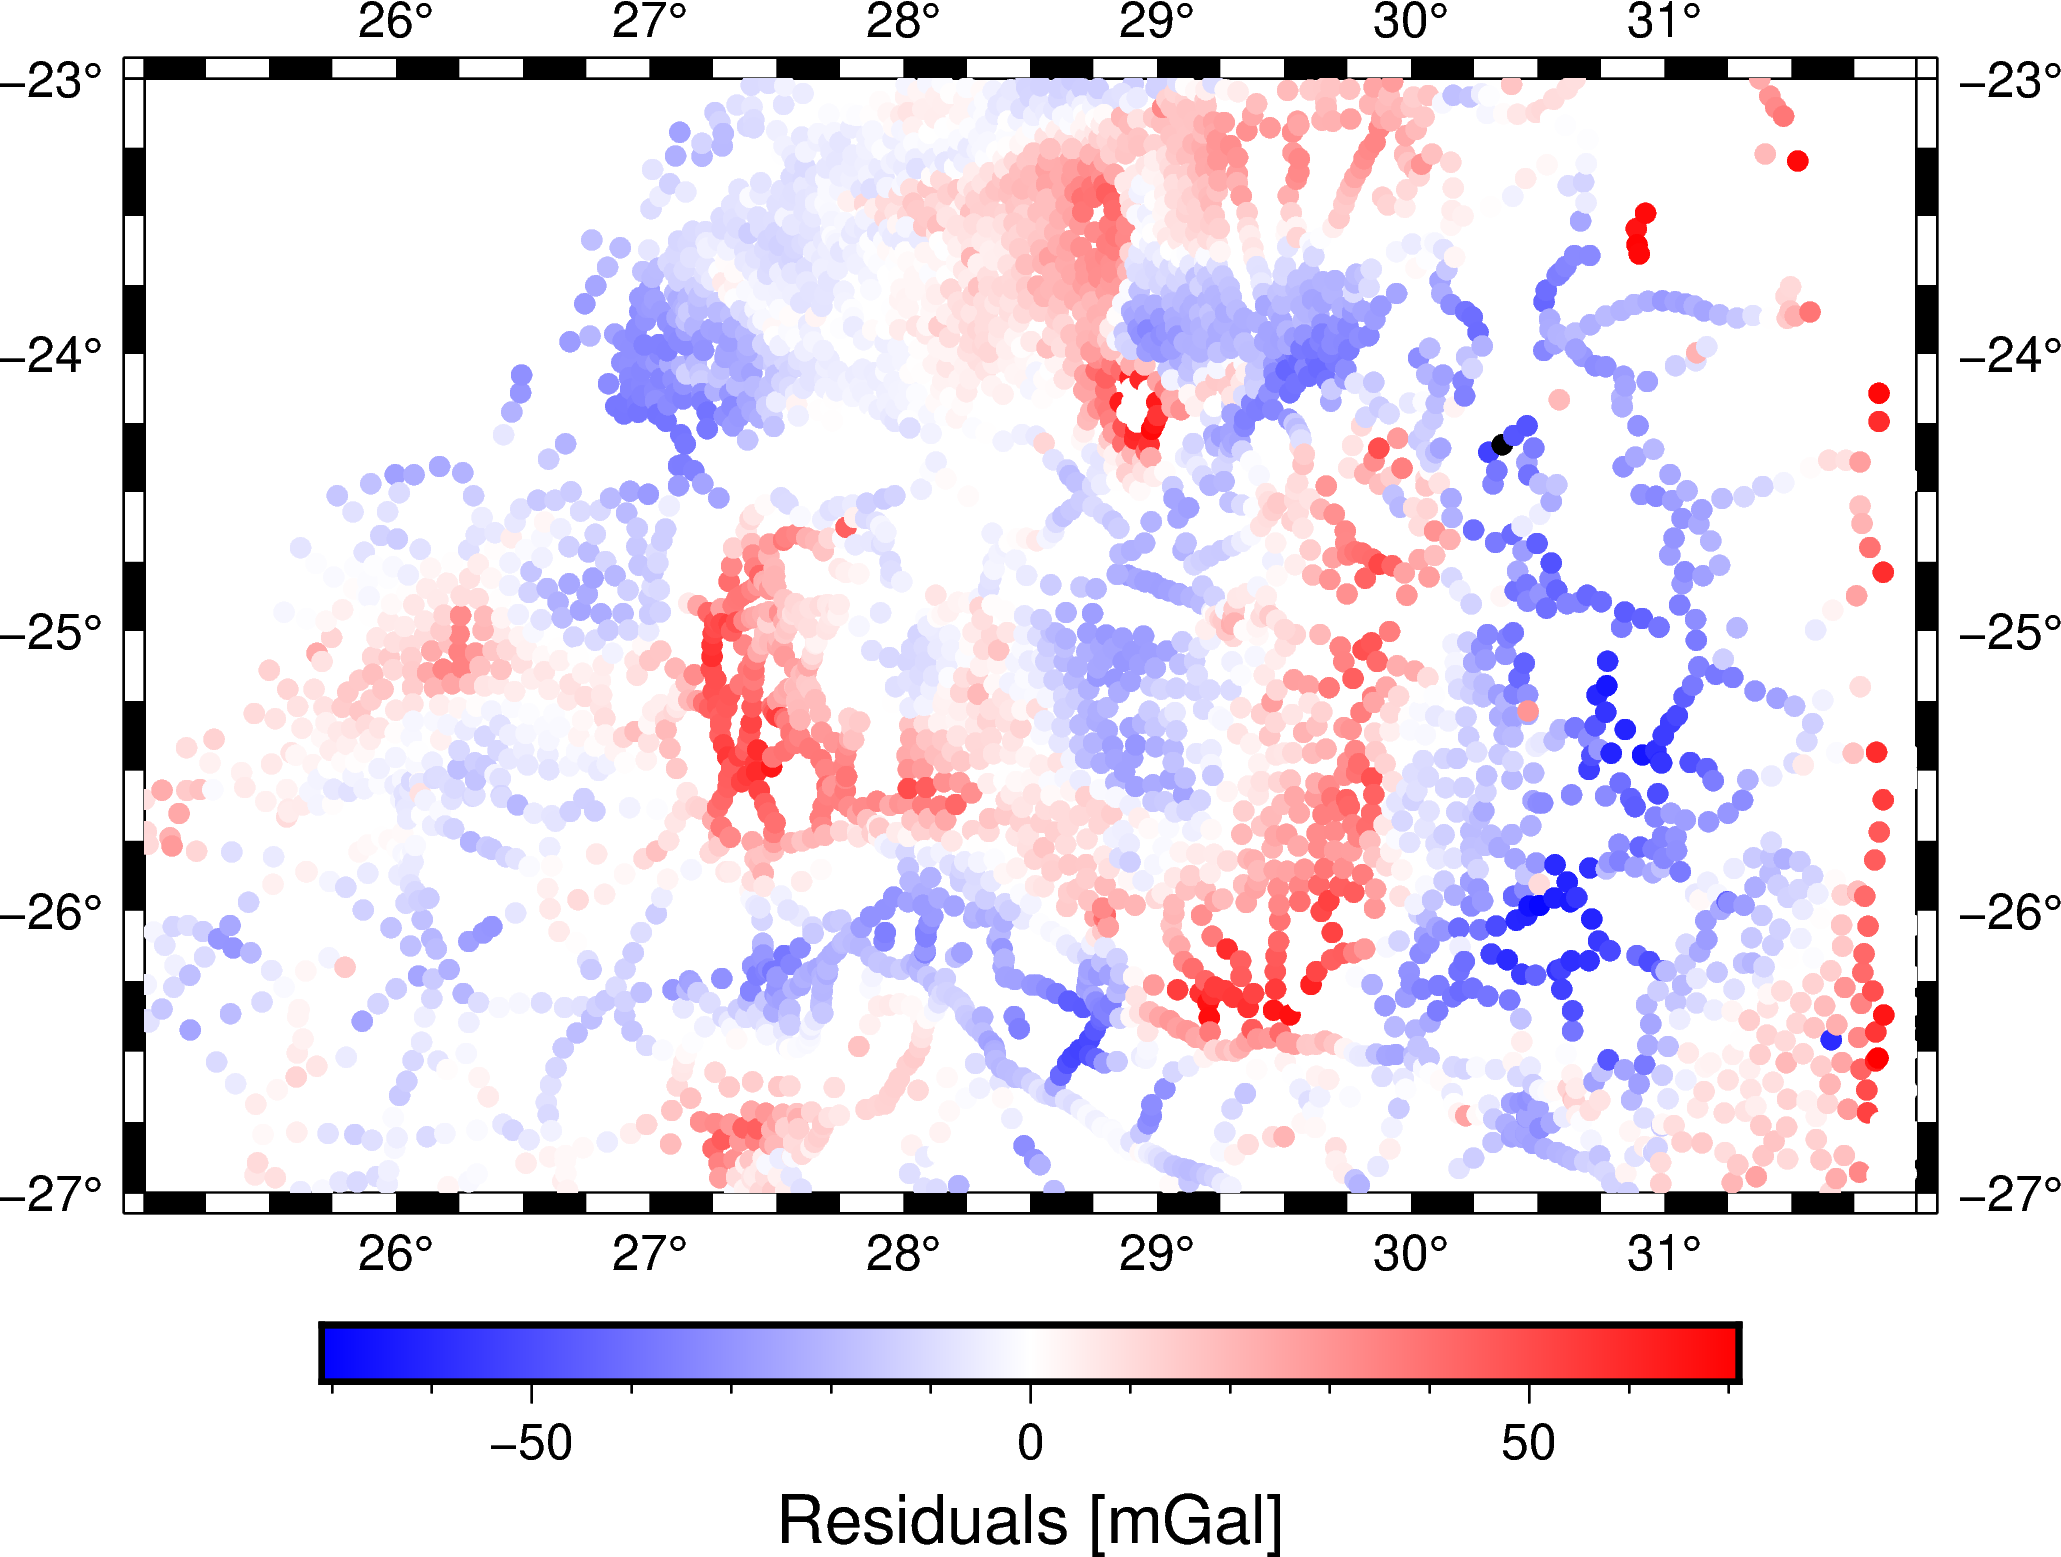

In [23]:
fig = pygmt.Figure()
fig.basemap(projection="M15c", region=region_deg, frame=True)

maxabs = np.quantile(np.abs(data.residuals_mgal), 0.99)
pygmt.makecpt(cmap="polar", series=[-maxabs, maxabs])
fig.plot(
    x=data.longitude,
    y=data.latitude,
    color=data.residuals_mgal,
    cmap=True,
    style="c5p",
)
fig.colorbar(frame='af+l"Residuals [mGal]"')
fig.show()

## Grid the residuals with Equivalent Sources

We can use [Harmonica](https://www.fatiando.org/harmonica) to grid the residuals though the equivalent sources technique

In [24]:
eql = hm.EquivalentSources(damping=100, depth=10e3)
eql.fit(coordinates, data.residuals_mgal)

EquivalentSources(damping=100, depth=10000.0)

In [25]:
grid = eql.grid(
    upward=2200,
    region=region_deg,
    spacing=0.01,
    data_names=["residuals"],
    dims=("latitude", "longitude"),
    projection=projection,
)
grid

/home/santi/.mambaforge/envs/iag-usp-2022-talk/lib/python3.9/site-packages/verde/base/base_classes.py:463: FutureWarning: The 'spacing', 'shape' and 'region' arguments will be removed in Verde v2.0.0. Please use the 'verde.grid_coordinates' function to define grid coordinates and pass them as the 'coordinates' argument.
  warnings.warn(


<xarray.Dataset>
Dimensions:    (latitude: 401, longitude: 699)
Coordinates:
  * longitude  (longitude) float64 25.01 25.02 25.03 25.04 ... 31.97 31.98 31.99
  * latitude   (latitude) float64 -27.0 -26.99 -26.98 ... -23.02 -23.01 -23.0
    upward     (latitude, longitude) float64 2.2e+03 2.2e+03 ... 2.2e+03 2.2e+03
Data variables:
    residuals  (latitude, longitude) float64 -0.6531 -0.6201 ... 18.58 18.39
Attributes:
    metadata:  Generated by EquivalentSources(damping=100, depth=10000.0)

In [ ]:
fig = pygmt.Figure()
fig.basemap(projection="M15c", region=region_deg, frame=True)

scale = np.quantile(np.abs(grid.residuals), 0.995)
pygmt.makecpt(cmap="polar", series=[-scale, scale], no_bg=True)
fig.grdimage(
    grid.residuals,
    shading="+a45+nt0.15",
    cmap=True,
)
fig.colorbar(frame='af+l"Residuals [mGal]"')
fig.show()

![Bushveld geologic map](nb-images/bushveld_igneous_complex_geology.jpg)

Geology and mineral exploration sites of the Bushveld Igneous Complex ([public domain](https://en.wikipedia.org/wiki/File:Bushveld_Igneous_Complex.png)). 